In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
DATA_PATH = './data/'
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0,8.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [3]:
videoFileName = DATA_PATH + "videos/cycle.mp4"

In [4]:
cap = cv2.VideoCapture(videoFileName)

In [5]:
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('sparse-output.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 20, (width,height))

# <font style="color:rgb(50,120,229)">Detect Corners for tracking them </font>
We will use the Shi Tomasi corner detection algorithm to find some points which we will track over the video. It is implemented in OpenCV using the function `goodFeaturesToTrack`.

### <font style="color:rgb(8,133,37)">Function Syntax </font>

```python
cv2.goodFeaturesToTrack(image, maxCorners, qualityLevel, minDistance[, mask[, blockSize]])
```
where,

- `image` - Input image
- `maxCorners` - maximum Number of corners to be detected
- `qualityLevel` - Parameter characterizing the minimal accepted quality of image corners. The parameter value is multiplied by the best corner quality measure
- `minDistance` - Minimum possible Euclidean distance between the returned corners.
- `mask` - Optional region of interest
- `blockSize` - Size of an average block for computing a derivative covariation matrix over each pixel neighborhood

We are specifying the parameters in a separate dictionary as given below.

In [6]:
# params for ShiTomasi corner detection
numCorners = 100
feature_params = dict( maxCorners = numCorners,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# <font style="color:rgb(50,120,229)">Set up the Lucas Kanade Tracker </font>
After detecting certain points in the first frame, we want to track them in the next frame. This is done using Lucas Kanade algorithm. It is implemented in OpenCV using the following function.

### <font style="color:rgb(8,133,37)">Function Syntax </font>

```python
nextPts, status, err = cv2.calcOpticalFlowPyrLK(prevImg, nextImg, prevPts[, winSize[, maxLevel[, criteria]]])
```

where,
- `prevImg` - previous image
- `nextImg` - next image
- `prevPts` - points in previous image
- `nextPts` - points in next image
- `winSize` - size of the search window at each pyramid level
- `maxLevel` - 0-based maximal pyramid level number; if set to 0, pyramids are not used (single level), if set to 1, two levels are used, and so on
- `criteria` - parameter, specifying the termination criteria of the iterative search algorithm (after the specified maximum number of iterations criteria.maxCount or when the search window moves by less than criteria.epsilon

In [7]:
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

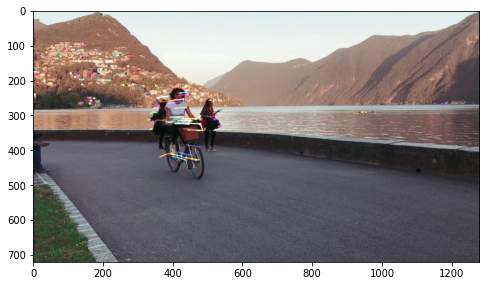

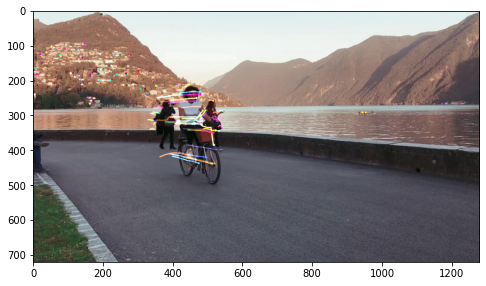

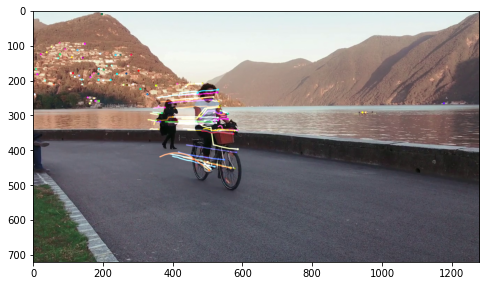

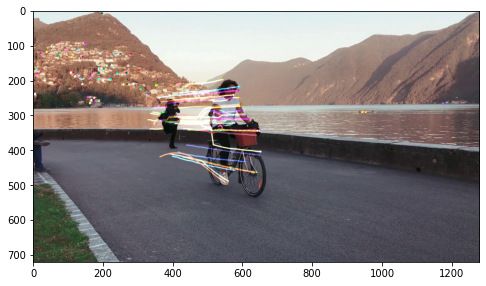

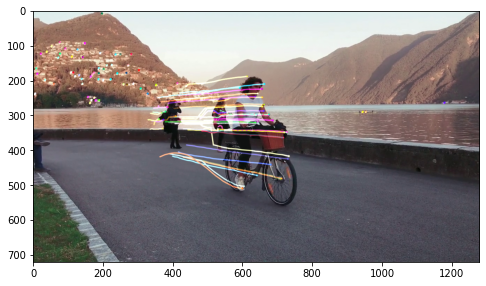

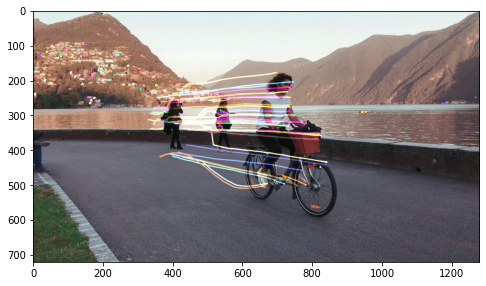

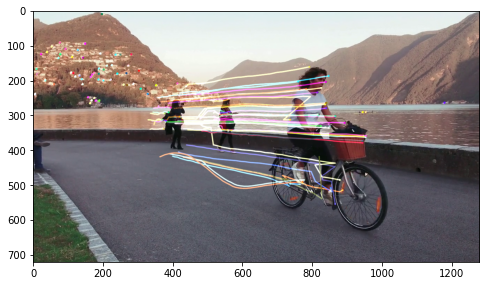

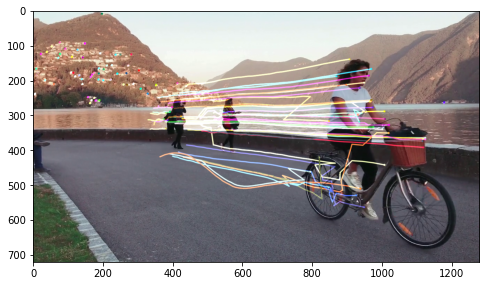

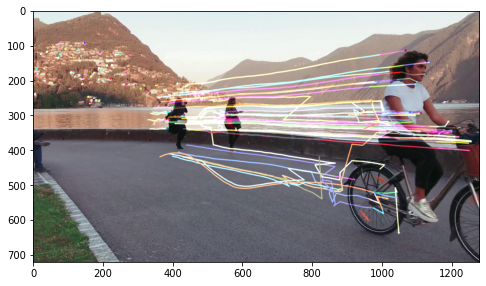

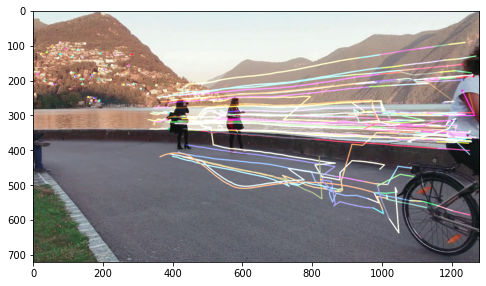

In [8]:
# Create some random colors
color = np.random.randint(0,255,(numCorners,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
old_points = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing the tracks 
mask = np.zeros_like(old_frame)
count = 0
while(1):
    ret,frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    count += 1
    # calculate optical flow
    new_points, status, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, old_points, None, **lk_params)

    # Select good points
    good_new = new_points[status==1]
    good_old = old_points[status==1]
    
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new, good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2, cv2.LINE_AA)
        cv2.circle(frame,(a,b),3,color[i].tolist(), -1)
    
    
    # display every 5th frame
    display_frame = cv2.add(frame,mask)
    out.write(display_frame)
    if count % 5 == 0:
        plt.imshow(display_frame[:,:,::-1])
        plt.show()
    if count > 50:
        break
#     k = cv.waitKey(30) & 0xff
#     if k == 27:
#         break
    
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    old_points = good_new.reshape(-1,1,2)

In [9]:
cap.release()
out.release()